In [1]:
import datetime 
from siphon.simplewebservice.wyoming import WyomingUpperAir
from metpy.units import units, pandas_dataframe_to_unit_arrays
import matplotlib.pyplot as plt
import metpy.plots as plots
import metpy.calc as mpcalc
import numpy as np
from matplotlib.pyplot import imread

%matplotlib inline

In [2]:
current_year = datetime.date.today().year
current_month = datetime.date.today().month
current_day = datetime.date.today().day
#datetime.date.today()

current_datetime = datetime.datetime(current_year, current_month, current_day, 12)
#current_datetime = datetime(2021, 7, 26, 12) #sept-10-2017 @ 0000z

Dias_de_la_semana = ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo']
tday = current_datetime.weekday()
Dia_de_la_semana = Dias_de_la_semana[tday]

Meses_del_Ano = ['', 'Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre',
                     'Octubre', 'Noviembre', 'Diciembre']
Mes_del_Ano = Meses_del_Ano[current_month]

fecha_y_hora = f'{Dia_de_la_semana} {current_day} de {Mes_del_Ano} de {current_year} - 8:00 a.m.'

In [3]:
station = '78486'

df = WyomingUpperAir.request_data(current_datetime, station)
d  = pandas_dataframe_to_unit_arrays(df)

mandatory_levels = [1000, 925, 850, 700, 500, 400, 300, 250, 200, 150, 100]

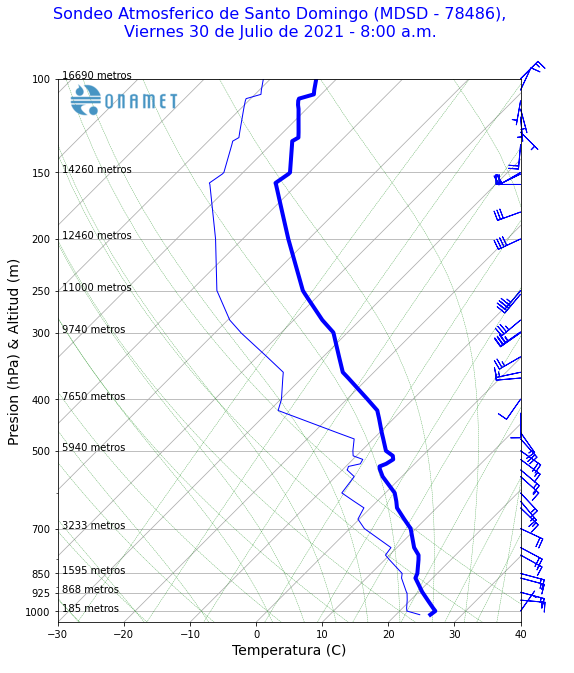

In [4]:
fig = plt.figure(figsize=(10, 10))
skew = plots.SkewT(fig, rotation = 45)

skew.plot(d['pressure'], d['temperature'], 'b', linewidth = 4)
skew.plot(d['pressure'], d['dewpoint'], 'b', linewidth = 1)

skew.ax.set_ylim(1050, 100)
skew.ax.set_xlim(-30, 40)

fig.suptitle(f'Sondeo Atmosferico de Santo Domingo (MDSD - 78486),\n{fecha_y_hora}', fontsize = 16, color = 'blue')
#fig.suptitle('Domingo 25 de julio de 2021 - 8:00 a.m.', fontsize = 20, y=0.)
plt.xlabel('Temperatura (C)', fontsize = 14)
plt.ylabel('Presion (hPa) & Altitud (m)', fontsize = 14)
plt.yticks(ticks=mandatory_levels)

interval = np.logspace(2, 3) * units.hPa
idx = mpcalc.resample_nn_1d(d['pressure'], interval)
skew.plot_barbs(d['pressure'][idx], d['u_wind'][idx], d['v_wind'][idx], barbcolor = 'blue', sizes = 
               dict(width = 0.01))

skew.plot_dry_adiabats(colors = 'green', linewidth = 0.4, alpha = 0.7)
skew.plot_moist_adiabats(colors = 'green', linewidth = 0.4, alpha = 0.7)

p_space = np.linspace(100, max(skew.ax.get_ylim())) * units.mbar
skew.plot_mixing_lines(pressure = p_space, colors = 'green', linewidth = 0.4, alpha = 0.7)
#skew.plot_mixing_lines(colors = 'green', linewidth = 0.4, alpha = 0.7)

logo = imread('onamet-110X32.png')
fig.figimage(logo, 70, 557, zorder=100)

#interval = [k for k in range(1000, 0, -100)] * units.hPa
interval = mandatory_levels * units.hPa
idx = mpcalc.resample_nn_1d(d['pressure'], interval)
for p, t, h  in zip(d['pressure'][idx], d['temperature'][idx], d['height'][idx]):
    if p >= 100 * units.hPa:
        skew.ax.text(0.01, p, f'{round(h.m, 0)} metros', fontsize=10, 
                     transform = skew.ax.get_yaxis_transform(which='tick2'))

In [5]:
# # skew.ax.axhline(lcl_pressure)




# skew.ax.axvline(x=0, ymin=0, ymax=0.28, color='c', linestyle='--', linewidth=2)
# lcl_pressure, lcl_temperature = mpcalc.lcl(d['pressure'][0], d['temperature'][0], d['dewpoint'][0])
# skew.plot(lcl_pressure, lcl_temperature, color = 'black', marker = 'o', markerfacecolor='red')

In [6]:
#https://stackoverflow.com/questions/65985185/cape-cin-returning-incorrect-values

# Calculate the mixed parcel--need to pass pressure as an additional variable to "mix" so that we get
# an appropriate "average pressure" to use as the mixed parcel

parcel_temperature, parcel_dewpoint, mixed_pressure = mpcalc.mixed_layer(d['pressure'], d['temperature'],
                                                           d['dewpoint'], d['pressure'],
                                                           height=d['height'], depth=500 * units.m)

# Replace the lowest part of the sounding with the mixed value
pressure_mixed = np.concatenate([np.atleast_1d(mixed_pressure), d['pressure'][d['pressure'] < mixed_pressure]])
temperature_mixed = np.concatenate([np.atleast_1d(parcel_temperature), 
                                    d['temperature'][d['pressure'] < mixed_pressure]])
dewpoint_mixed = np.concatenate([np.atleast_1d(parcel_dewpoint), d['dewpoint'][d['pressure'] < mixed_pressure]])

# Calculate the parcel profile, including the LCL--this interpolates the sounding to the level of the LCL
# as well, so that the profile and all variables have the same points

parcel_path_LCL = mpcalc.parcel_profile(pressure_mixed, parcel_temperature, parcel_dewpoint)
skew.plot(pressure_mixed, parcel_path_LCL, color = 'k', linewidth = 0.4)

mask = pressure_mixed >= 200 * units.hPa
skew.shade_cape(pressure_mixed, temperature_mixed, parcel_path_LCL)
skew.shade_cin(pressure_mixed[mask], temperature_mixed[mask], parcel_path_LCL[mask])



In [7]:
lcl_pressure, lcl_temperature = mpcalc.lcl(mixed_pressure, parcel_temperature, parcel_dewpoint)
lfc_pressure, lfc_temperature = mpcalc.lfc(pressure_mixed, temperature_mixed, dewpoint_mixed, which = 'bottom')
el_pressure, el_temperature = mpcalc.el(pressure_mixed, temperature_mixed, dewpoint_mixed)

cape, cin = mpcalc.cape_cin(pressure_mixed, temperature_mixed, dewpoint_mixed, parcel_path_LCL)

li = mpcalc.lifted_index(pressure_mixed, temperature_mixed, parcel_path_LCL)

pw = mpcalc.precipitable_water(d['pressure'], d['dewpoint'])



In [8]:
idx = np.where(d['pressure'] == 850 * units.hPa)
idx = idx[0][0]
t_850 = d['temperature'][idx]
td_850 = d['dewpoint'][idx]
ws_850 = d['speed'][idx]
wd_850 = d['speed'][idx]
pressure_set_from_850  = d['pressure'][idx:]
parcel_path_850 = mpcalc.parcel_profile(pressure_set_from_850, d['temperature'][idx], d['dewpoint'][idx])

idx = np.where(d['pressure'] == 500 * units.hPa)
idx = idx[0][0]
t_500 = d['temperature'][idx]
tp_500 = parcel_path_LCL[idx].to(units.degC)
ws_500 = d['speed'][idx]
wd_500 = d['speed'][idx]


idx = np.where(d['pressure'] == 700 * units.hPa)
idx = idx[0][0]
t_700 = d['temperature'][idx]
td_700 = d['dewpoint'][idx]

idx = np.where(pressure_set_from_850 == 500 * units.hPa)
idx = idx[0][0]
tp_500_850 = parcel_path_850[idx].to(units.degC)


kinx = ( t_850 - t_500 ) + td_850 - ( t_700 - td_700 ) 
ctot = td_850 - t_500 
vtot = t_850 - t_500 
totl = ( t_850 - t_500 ) + ( td_850 - t_500 )
show = t_500 - tp_500_850


#######SWET = 12 * TD850 + 20 * TERM2 + 2 * SKT850 + SKT500 + SHEAR 
a = 0
wd_500_850 = wd_500.m - wd_850.m
if 130 <= wd_850.m <= 250 and 210 <= wd_500.m <= 310 and  wd_500_850 > 0 and ws_500.m >= 15 and ws_850.m >= 15:
    a = 1
    
b=0
if totl.m > 49:
    b = 1
    
swet = 12*td_850.m + 20 * b * totl.m + 2*ws_850.m + ws_500.m + 125 * a *(float(np.sin(wd_500.m - wd_850.m)) + 0.2)


#######Frezing Level
freezing_temperature = 0 * units.degC
zero_temp_index = np.abs(d['temperature'] - freezing_temperature).argmin()
freezing_level  = d['height'][zero_temp_index]
closest_to_zero = np.abs(d['temperature'] - freezing_temperature)[zero_temp_index]
if closest_to_zero.m > 1 or closest_to_zero.m < -1:
    freezing_level = 9999 * units.degC


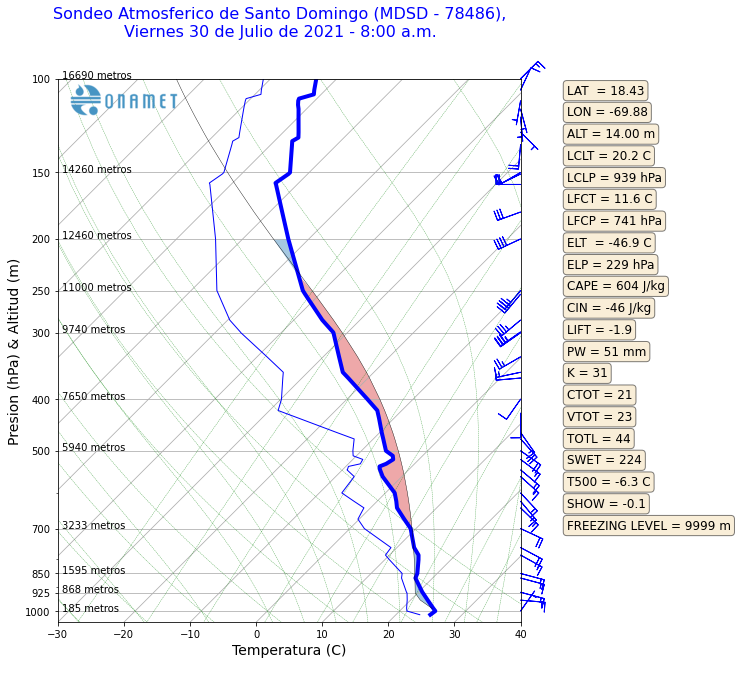

In [9]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

txts     = [f'LAT  = 18.43', f'LON = -69.88', f'ALT = 14.00 m',            
            f'LCLT = {round(lcl_temperature.m, 1)} C', f'LCLP = {int(lcl_pressure.m)} hPa', 
            f'LFCT = {round(lfc_temperature.m, 1)} C', f'LFCP = {int(lfc_pressure.m)} hPa',
            f'ELT  = {round(el_temperature.m, 1)} C', f'ELP = {int(el_pressure.m)} hPa',
            f'CAPE = {int(cape.m)} J/kg', f'CIN = {int(cin.m)} J/kg',
            f'LIFT = {round(float(li.m), 1)}', f'PW = {int(pw.m)} mm', f'K = {int(kinx.m)}',
            f'CTOT = {int(ctot.m)}', f'VTOT = {int(vtot.m)}', f'TOTL = {int(totl.m)}',
            f'SWET = {int(swet)}', f'T500 = {round(t_500.m, 1)} C', f'SHOW = {round(show.m, 1)}',
            f'FREEZING LEVEL = {int(freezing_level.m)} m']

xtxt = 1.1
ytxt = 0.99

for txt in txts:
    skew.ax.text(xtxt, ytxt, txt, transform=skew.ax.transAxes, fontsize=12,
                 verticalalignment='top', bbox=props)
    ytxt = ytxt - 0.04
fig

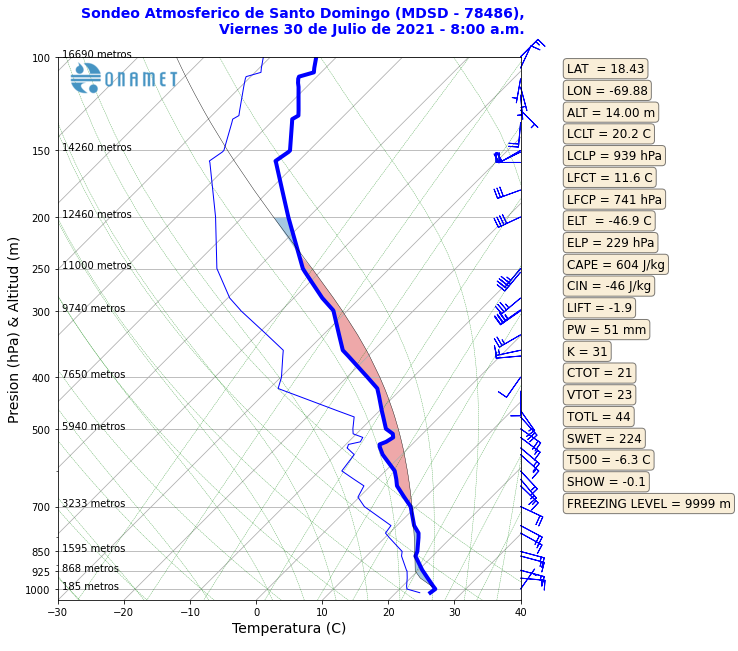

In [17]:
# t_array = skew.ax.get_xticks() * units.degC
# mpcalc.find_intersections(pressure_mixed[:18], temperature_mixed,
#                                             t_array, direction='decreasing',
#                                             log_x=True)

fig.suptitle(f'Sondeo Atmosferico de Santo Domingo (MDSD - 78486),\n{fecha_y_hora}', x = 0.84, y = 0.95, 
             weight = 'bold', horizontalalignment= 'right', fontsize = 14, color = 'b')
fig

926.732401807756 hectopascal 22.164698845220737 degree_Celsius


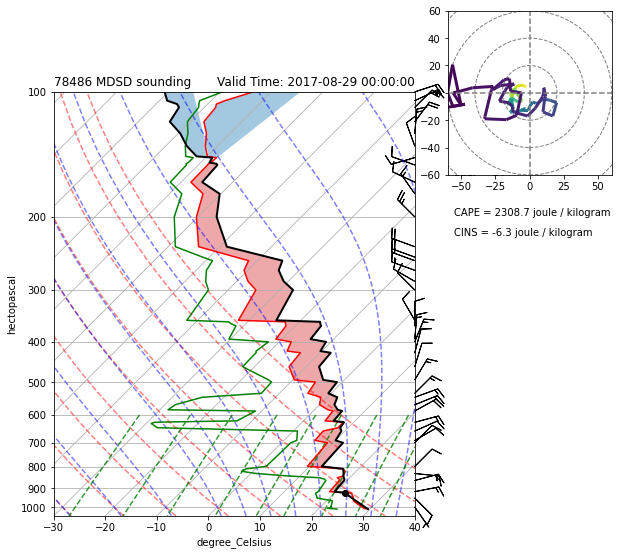

In [33]:
# Copyright (c) 2015,2016,2017 MetPy Developers modified by Kyle Y. Parsotan.
# Distributed under the terms of the BSD 3-Clause License.
# SPDX-License-Identifier: BSD-3-Clause
# Sounding data from https://mesonet.agron.iastate.edu/archive/raob/
# https://unidata.github.io/python-gallery/examples/SkewT_Example.html

"""
=================
Advanced Sounding
=================
Plot a sounding using MetPy with more advanced features.
Beyond just plotting data, this uses calculations from `metpy.calc` to find the lifted
condensation level (LCL) and the profile of a surface-based parcel. The area between the
ambient profile and the parcel profile is colored as well.
"""
# import datasets

import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import metpy.calc as mpcalc
from datetime import datetime
from metpy.plots import SkewT, Hodograph
from metpy.cbook import get_test_data
from metpy.units import pandas_dataframe_to_unit_arrays, units
from siphon.simplewebservice.wyoming import WyomingUpperAir
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

######################################################################
# Set time using a datetime object and station as variables
#+- 3 days of hurricane Irma's formation as a cat 5 near Santo Domingo 
#San Juan station doesn't work

#she  was a cat 5 between sep 6 to 8 00Z

mon = [8]

dt = [29]

tme = [0, 12]

# mon = [8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9] #16

# dt  = [29, 30, 31, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] #16

# tme = [0, 12, 0, 12, 0, 12, 0, 12, 0, 12, 0, 12, 0, 12, 0, 12, 0] #16



# dt = datetime(2017, 8, 27, 0)
      
station = 'MDSD'

for i in range (len(dt)):
    
    dt1 = datetime(2017, mon[i], dt[i], tme[i])

    ######################################################################
    # Grab Remote Data
    # ----------------
    
    # This requires an internet connection to access the sounding data from a
    # remote server at the University of Wyoming.
    
    # Read remote sounding data based on time (dt) and station
    df = WyomingUpperAir.request_data(dt1, station)
    
    # Create dictionary of united arrays
    data = pandas_dataframe_to_unit_arrays(df)
    
    ######################################################################
    # Isolate variables and attach units
    
    # Isolate united arrays from dictionary to individual variables
    #Pressure in hPa = mb
    p = data['pressure']
    # Temps in Celsius
    T = data['temperature']
    
    #Temp in Kelvin
    T_K = data['temperature'].to('kelvin')
    
    # Temps in Celsius
    Td = data['dewpoint']
    
    #Temps in Kelvin
    Td_K = data['dewpoint'].to('kelvin')
    
    # # knots
    # u = data['u_wind']
    # v = data['v_wind']
    # wind speed kts
    wind_speed = data['speed']
    # direction degrees
    wind_dir = data['direction']
    # wind components
    u, v = mpcalc.wind_components(wind_speed, wind_dir)
    # height in  Meter
    el = data['elevation']
    # lat, lon in degrees
    lat = data['latitude']
    lon = data['longitude']
    
    ##########################################################################
    # Thermodynamic Calculations
    # --------------------------
    #
    # Often times we will want to calculate some thermodynamic parameters of a
    # sounding. The MetPy calc module has many such calculations already implemented!
    #
    # * **Lifting Condensation Level (LCL)** - The level at which an air parcel's
    #   relative humidity becomes 100% when lifted along a dry adiabatic path.
    # * **Parcel Path** - Path followed by a hypothetical parcel of air, beginning
    #   at the surface temperature/pressure and rising dry adiabatically until
    #   reaching the LCL, then rising moist adiabatially.
    
    # Calculate the LCL
    lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
    
    #prints LCL
    print(lcl_pressure, lcl_temperature)
    
    # calculate the lfc
    lfc = mpcalc.lfc(p, T, Td)
    
    # calculate the EL
    EL = mpcalc.el(p, T, Td)
    
    # Calculate the parcel profile.
    parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
    
    #Calculate CAPE/ CINS
    CAPE, CINS = mpcalc.cape_cin(p, T, Td, parcel_prof, which_lfc='bottom', which_el='top')
    
    #Calculate the parcel profile including the LCL 
    #get new temperature, pressure, and dewpoint that include values interpolated at LCL
    
    p,t,td,prof_t = mpcalc.parcel_profile_with_lcl(p,T,Td)
    # print(p,t,td,prof_t)
    
    #calculate saturation vapor pressure
    # svp = 
    
    #Calculate water vapor ratio from dewpoint
    
    # mv = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(Td), p)
    
    # Calculate the virtual temperature for the atmospheric temperature profile
    # and for the parcel's profile
    # tv = mpcalc.virtual_temperature(t, mv)
    # prof_tv = mpcalc.virtual_temperature(prof_t, mv)

    # Calculate cape/cin using the virtual temperature for *both* temperatures
    # VCAPE, VCINS = mpcalc.cape_cin(p, tv, td, prof_tv)

    #Calculates temps. virtual
    # Tv = mpcalc.virtual_temperature(T[0], mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(Td[0]), p[0]))
    
    # Profile Virtual temperature
    # parcel_prof_virtual = mpcalc.parcel_profile_virtual(p, Tv, Td[0]).to('degC')
    
    #Calculate CAPEV / CINSV Not working properly
    # CAPEV, CINSV = mpcalc.capev_cinv(p, Tv, Td[0], parcel_prof, which_lfc='bottom', which_el='top')

    #Calculuate SHOW = T500 - Tparcel WRONG NUMBERS
    
    # SHOW = T[32] - T[0]
    
    #Calculate LIFT = T500 - Tparcel WRONG NUMBERS
    
    # LIFT = T[32] - T[0]

    # SWET	= 12 * TD850 + 20 * TERM2 + 2 * SKT850 + SKT500 + SHEAR
    
    # SHEAR = 125 * [ SIN ( DIR500 - DIR850 ) + .2 ]
    
    # TERM2 = MAX ( TOTL - 49, 0 )
    
    # SWET = 12 * Td[13] + 20 * TERM2 + 2 *  TERM2 + 2 * [] + [] + SHEAR
    
    #Calculate K index KINX	= ( T850 - T500 ) + TD850 - ( T700 - TD700 )
    
    # KINX = (T[13] - T[32]) + Td[13] - (T[19] - Td[19])
    
    #Calculate CTOT CTOT	 = TD850 - T500
    
    # CTOT = T[19] - T[32]
    
    #Calculate TOTL	= ( T850 - T500 ) + ( TD850 - T500 )
    
    
    #calculate Bulk Richardson number BRCH	= CAPE / ( 0.5 * U**2 )
    
    #calculate 	BRCV = CAPV / ( 0.5 * U**2 )
    
    #calculate 	LCLT = [1 / ( 1 / ( DWPK - 56 ) + LN ( TMPK / DWPK ) / 800 )] + 56
    
    #calculate 	LCLP = PRES * ( LCLT / ( TMPC + 273.15 ) ) ** ( 1 / KAPPA )
    
    #calculate THTK	= ( Z500 - Z1000 )
    
    # THTK = 
    
    ######################################################################
    # Make Skew-T Plot
    # ----------------
    #
    # The code below makes a basic skew-T plot using the MetPy plot module
    # that contains a SkewT class.
    #
    
    # Create a new figure. The dimensions here give a good aspect ratio
    fig = plt.figure(figsize=(10, 11))
    
    # Grid for plots
    gs = gridspec.GridSpec(3, 3)
    skew = SkewT(fig, rotation=45, subplot=gs[:, :2])
    
    # limit the wind barbs 
    
    mask = p >= 100 * units.hPa
    
    Interval = np.arange(100, 1000, 50) * units.hPa
    
    interval = np.logspace(2,3) * units.hPa
    
    idx = mpcalc.resample_nn_1d(p, interval)
    p = p[:95]
    # Plot the data using normal plotting functions, in this case using
    # log scaling in Y, as dictated by the typical meteorological plot
    skew.plot(p, T, 'r')
    skew.plot(p, Td, 'g')
    skew.plot_barbs(p[idx], u[idx], v[idx])
    skew.ax.set_ylim(1050, 100)
    
    # Plot LCL temperature as black dot
    skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black', alpha = 1) #alpha = 0 make dot transparents
    
    # Plot the parcel profile as a black line
    skew.plot(p, parcel_prof, 'k', linewidth=2)
    
    # Shade areas of CAPE and CIN
    skew.shade_cin(p, T, parcel_prof)
    skew.shade_cape(p, T, parcel_prof)
    
    # Add the relevant special lines
    skew.plot_dry_adiabats()
    skew.plot_moist_adiabats()
    skew.plot_mixing_lines()
    
    # Good bounds for aspect ratio
    skew.ax.set_xlim(-30, 40)
    
    # Add some descriptive titles
    plt.title('78486 {} sounding'.format(station), loc='left')
    plt.title('Valid Time: {}'.format(dt1), loc='right')
    plt.annotate('SLAT = 18.43', xy=(200,300), xytext=(400,380), xycoords='axes points')
    plt.annotate('SLON = -69.88', xy=(200,300), xytext=(400,360), xycoords='axes points')
    plt.annotate('SELV = 14',  xy=(200,300), xytext=(400,340), xycoords='axes points')
    # plt.annotate('SHOW = ' + str(np.round(SHOW,1)), xy=(200,300), xytext=(400,320), xycoords='axes points')
    # plt.annotate('LIFT = ' + str(np.round(LIFT,1)), xy=(200,300), xytext=(400,230), xycoords='axes points')
    # plt.annotate('LFCV = ' + str(np.round(CINS,1)), xy=(200,300), xytext=(400,280), xycoords='axes points')
    # plt.annotate('SWET  = '+ str(np.round(SWET,1)), xy=(200,300), xytext=(400,280), xycoords='axes points')
    # plt.annotate('KINX  = '+ str(np.round(KINX,1)), xy=(200,300), xytext=(400,240), xycoords='axes points')
    # plt.annotate('CTOT = '+ str(np.round(CTOT,1)), xy=(200,300), xytext=(400,200), xycoords='axes points')
    # plt.annotate('VTOT = ' + str(np.round(CINS,1)), xy=(200,300), xytext=(400,280), xycoords='axes points')
    # plt.annotate('TOTL = ' + str(np.round(CINS,1)), xy=(200,300), xytext=(400,280), xycoords='axes points')
    plt.annotate('CAPE = ' + str(np.round(CAPE,1)), xy=(200,300), xytext=(400,300), xycoords='axes points')
    # plt.annotate('CAPEV = ' + str(np.round(CAPEV,1)), xy=(200,300), xytext=(400,300), xycoords='axes points')
    plt.annotate('CINS = ' + str(np.round(CINS,1)), xy=(200,300), xytext=(400,280), xycoords='axes points')
    # plt.annotate('CINSV = ' + str(np.round(CINSV,1)), xy=(200,300), xytext=(400,280), xycoords='axes points')
    # plt.annotate('EQLV = ' + str(np.round(CINS,1)), xy=(200,300), xytext=(400,280), xycoords='axes points')
    # plt.annotate('EQTV = ' + str(np.round(CINS,1)), xy=(200,300), xytext=(400,280), xycoords='axes points')
    # plt.annotate('LFCT = ' + str(np.round(CINS,1)), xy=(200,300), xytext=(400,280), xycoords='axes points')
    # plt.annotate('LFCV' = ' + str(np.round(CINS,1)), xy=(200,300), xytext=(400,280), xycoords='axes points')
    # plt.annotate('BRCH' = ' + str(np.round(CINS,1)), xy=(200,300), xytext=(400,280), xycoords='axes points')
    # plt.annotate('BRCV' = ' + str(np.round(CINS,1)), xy=(200,300), xytext=(400,280), xycoords='axes points')
    # plt.annotate('LCLT' = ' + str(np.round(CINS,1)), xy=(200,300), xytext=(400,280), xycoords='axes points')
    # plt.annotate('LCLP' = ' + str(np.round(CINS,1)), xy=(200,300), xytext=(400,280), xycoords='axes points')
    # plt.annotate('LCLE' = ' + str(np.round(CINS,1)), xy=(200,300), xytext=(400,280), xycoords='axes points')
    # plt.annotate('MLTH' = ' + str(np.round(CINS,1)), xy=(200,300), xytext=(400,280), xycoords='axes points')
    # plt.annotate('MLMR' = ' + str(np.round(CINS,1)), xy=(200,300), xytext=(400,280), xycoords='axes points')
    # plt.annotate('THCK' = ' + str(np.round(CINS,1)), xy=(200,300), xytext=(400,280), xycoords='axes points')
    # plt.annotate('PWAT' = ' + str(np.round(CINS,1)), xy=(200,300), xytext=(400,280), xycoords='axes points')
    
                 
    # Create a hodograph
    # ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1)
    ax = fig.add_subplot(gs[0, -1])
    h = Hodograph(ax, component_range=60.)
    h.add_grid(increment=20)
    # h.plot(u, v)
    h.plot_colormapped(u, v, p)
    #save the figures for the date it was near Santo Domingo
    # plt.savefig('parsotak_Hurricane_Irma_skew-T_sfc_press_temp' + str(i) + '.png', orientation = 'landscape', papertype = 'letter', dpi=350)
    # plt.savefig('parsotak_Hurricane_Irma_skew-T_virtual_temp' + str(i) + '.png', orientation = 'landscape', papertype = 'letter', dpi=350)
    # Show the plot
    plt.show()
    
    #create animations
    # plt.rcParams['animation.html'] = 'jshtml'
    
    # anim = manimation.
    
    #convert from png to gif using linux
    
    #convert -delay 10 -loop 0 *.png animation.gif
